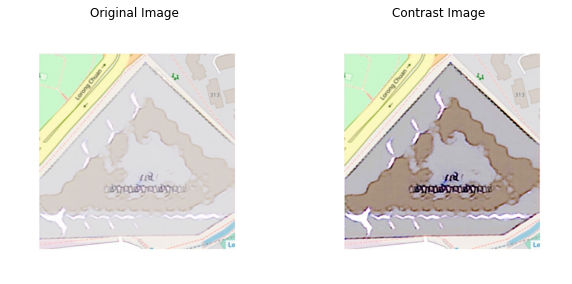

In [16]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

# Load the images
mask_image = Image.open('C:\\Users\\phuay\\Desktop\\m.jpg')
original_image = Image.open('C:\\Users\\phuay\\Desktop\\p.jpg')

# Convert to NumPy arrays
mask_array = np.array(mask_image)
original_array = np.array(original_image)

# Define a function to create a mask with a threshold
def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

# Create a binary mask with a threshold from the blue region in the mask image
mask_color = [0, 0, 255]  # bright blue
binary_mask = create_binary_mask(mask_array, mask_color)

# Extract region A from the original image that corresponds to the binary mask
region_A = original_array.copy()
region_A[~binary_mask] = [255, 255, 255]  # making non-masked region white

# Convert region A back to a PIL image and enhance its contrast
region_A_image = Image.fromarray(region_A)
enhancer = ImageEnhance.Contrast(region_A_image)
enhanced_region_A = enhancer.enhance(3.0) 
enhanced_region_A_array = np.array(enhanced_region_A)

# Combine the enhanced region with the original image
final_image_array = original_array.copy()
final_image_array[binary_mask] = enhanced_region_A_array[binary_mask]
contrast_image = Image.fromarray(final_image_array)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(contrast_image)
plt.title('Contrast Image')
plt.axis('off')
plt.show()

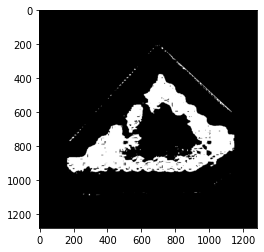

In [17]:
import cv2

def extract_brown_regions(input_array):
    image = cv2.cvtColor(input_array, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_brown = np.array([5, 50, 20])
    upper_brown = np.array([25, 255, 220])
    mask = cv2.inRange(hsv, lower_brown, upper_brown)
    return mask

# Create a mask for brown regions
contrast_image_array = np.array(final_image_array)
brown_mask = extract_brown_regions(contrast_image_array)

# Apply a bitwise AND operation between the blue mask and the brown mask
brown_blue_mask = cv2.bitwise_and(brown_mask, brown_mask, mask=binary_mask.astype(np.uint8)*255)

# Convert the final array to a PIL Image
final_image = Image.fromarray(brown_blue_mask)

# Display the result
plt.imshow(brown_blue_mask, cmap='gray')
plt.show()

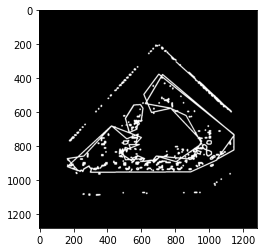

In [18]:
def approx_contours(contours, epsilon_factor=0.02):
    """Approximate contours to simplify shape."""
    approximated_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approximated_contours.append(approx)
    return approximated_contours

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(brown_blue_mask, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Approximate contours to simplify shapes
approximated = approx_contours(contours)

# Draw the contours on the original image
result = cv2.drawContours(brown_blue_mask.copy(), approximated, -1, (255), 10)

# Draw the contours on the blank image
blank_image = np.zeros_like(brown_blue_mask)
result = cv2.drawContours(blank_image, approximated, -1, (255), 5)

# Display the result
plt.imshow(result, cmap='gray')
plt.show()

## V1

In [19]:
# def clean_noise(contours):
#     cleaned_contours = []
#     for contour in contours:
#         if cv2.contourArea(contour) > 100:  # Threshold area to filter out smaller noise
#             cleaned_contours.append(contour)
#     return cleaned_contours

# def thicken_contours(image, contours):
#     blank = np.zeros_like(image)
#     thickened_image = cv2.drawContours(blank, contours, -1, (255), 10)  # Drawing contours with increased thickness
#     return thickened_image

# cleaned_contours = clean_noise(approximated)
# thickened_mask = thicken_contours(blank_image, cleaned_contours)
# result = cv2.drawContours(np.zeros_like(blank_image), cleaned_contours, -1, (255), 5)

# plt.imshow(result, cmap='gray')
# plt.show()

## V2

In [20]:
# def approx_contours(contours, epsilon_factor=0.01):  
#     approximated_contours = []
#     for contour in contours:
#         epsilon = epsilon_factor * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)
#         approximated_contours.append(approx)
#     return approximated_contours

# approximated = approx_contours(approximated)

# # Fill the contours to create solid shapes
# filled_image = np.zeros_like(blank_image)
# cv2.drawContours(filled_image, approximated, -1, (255), thickness=cv2.FILLED)

# # Remove contours with small areas
# for contour in approximated:
#     if cv2.contourArea(contour) < 800:  # adjust this threshold value as required
#         cv2.drawContours(filled_image, [contour], -1, (0), thickness=cv2.FILLED)

# plt.imshow(filled_image, cmap='gray')
# plt.show()

# kernel_size = 15  # This value might need adjustment based on the spacing between your contours
# kernel = np.ones((kernel_size, kernel_size), np.uint8)

# # Dilate to join nearby contours
# dilated_image = cv2.dilate(filled_image, kernel, iterations=1)

# # (Optional) Erode to reduce the size of the dilated areas
# eroded_image = cv2.erode(dilated_image, kernel, iterations=1)




## V3
- try to to clean then dialate then clean again  (now: dialate then clean)

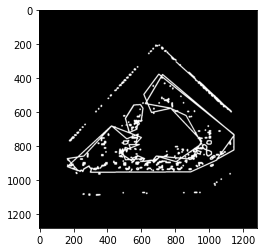

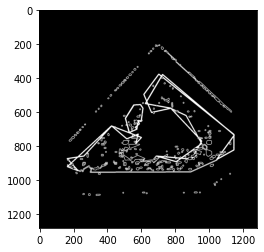

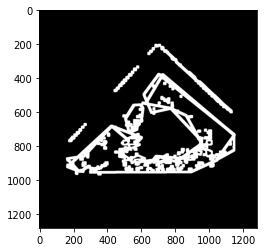

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'approximated' is the variable containing the approximated contours

# Create an empty blank image
blank_image = np.zeros((brown_blue_mask.shape[0], brown_blue_mask.shape[1]), dtype=np.uint8)

# Draw the 'approximated' contours onto the blank image
cv2.drawContours(blank_image, approximated, -1, (255), thickness=5)

plt.imshow(blank_image, cmap='gray')
plt.show()

# Remove contours with small areas
for contour in approximated:
    if cv2.contourArea(contour) < 2000:  # Adjust this threshold value as required
        cv2.drawContours(blank_image, [contour], -1, (0), thickness=cv2.FILLED)

plt.imshow(blank_image, cmap='gray')
plt.show()

# Dilate the contours to join close contours
kernel_size = 10  # Adjust based on the spacing between your contours
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.dilate(blank_image, kernel, iterations=1)

# Get contours from the dilated image
contours_dilated, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Fill the contours from the dilated image to create solid shapes
filled_image = np.zeros_like(dilated_image)
cv2.drawContours(filled_image, contours_dilated, -1, (255), thickness=cv2.FILLED)

# Remove contours with small areas
for contour in contours_dilated:
    if cv2.contourArea(contour) < 1200:  # Adjust this threshold value as required
        cv2.drawContours(filled_image, [contour], -1, (0), thickness=cv2.FILLED)

plt.imshow(filled_image, cmap='gray')
plt.show()


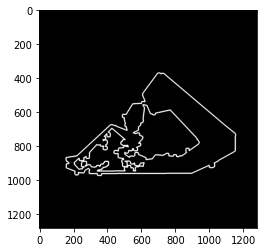

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def centroid(contour):
    """Calculate the centroid of a contour."""
    M = cv2.moments(contour)
    if M["m00"] == 0:
        return None
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)

# Filter out contours that are too close to the boundaries
filtered_contours = []
for contour in contours_dilated:
    c = centroid(contour)
    if c is None:
        continue
    distances = [np.linalg.norm(np.array(c) - point[0]) for point in contour]
    min_distance = min(distances)
    if min_distance >=30:  # Distance
        filtered_contours.append(contour)

blank_image = np.zeros((brown_blue_mask.shape[0], brown_blue_mask.shape[1]), dtype=np.uint8)
cv2.drawContours(blank_image, filtered_contours, -1, (255), thickness=5)
plt.imshow(blank_image, cmap='gray')
plt.show()